In [1]:
# %matplotlib notebook

from matplotlib import pylab
from astropy.coordinates import SkyCoord
import integralclient as ic

import time
import numpy as np

from astropy.table import Table, vstack
from astropy.io import fits
import glob
from scipy import stats
from astropy.time import Time

failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
failed to get AUTH with homefile due to: [Errno 2] No such file or directory: '/home/savchenk/.secret-client-user'


In [2]:
RA=293.732
Dec=21.8967222
tstart_rel_mseconds=300.0
tstop_rel_seconds=300.0
t0_utc = "2023-05-22T15:30:33.000" 
# t0_utc=Time(Time("2022-10-14T19:21:47").mjd - 8.632259375000002/24/3600, format='mjd').isot.replace(" ", "T") # hard x-ray
# t0_utc="2022-10-14T19:21:47"
# rt=1
# nrt=1
# arc=0
required_completeness=0.6
# mode="rt" # scw|rt|arc
mode="scw" # scw|rt|arc
global_snr_threshold=3.
negative_excesses=0

In [3]:
t0_utc

'2023-05-22T15:30:33.000'

In [4]:
if mode == "scw":
    rt=0
    nrt=1
    arc=0
elif mode == "rt":
    rt=1
    nrt=0
    arc=0
elif mode == "arc":
    rt=0
    nrt=0
    arc=1
elif mode == "flags":
    print("mode set by flags")
else:
    raise Exception("unknown mode: {}, allowed: scw, rt".format(mode))

In [5]:
source_coord = SkyCoord(RA, Dec, unit = "deg")

In [6]:
import importlib

In [7]:
# /home/savchenk/work/transients/workflows/integral-all-sky

import integralenv
importlib.reload(integralenv)

arc_root_prefix = integralenv.get_arc_root_prefix()

In [8]:
ic.converttime("UTC", t0_utc, "ANY")

{'IJD': '8542.647016018518',
 'OBT': '9131878556280477',
 'OBTFITS': '    2   118903447   698013 :    32 29029 10618 42653',
 'REVNUM': '2642',
 'SCWID': '264200690021 is close',
 'UTC': '2023-05-22T15:30:33.000',
 'YYYYDDDHH': '202314215'}

In [9]:
now_ijd = float(ic.converttime("UTC",time.strftime("%Y-%m-%dT%H:%M:%S"),"IJD"))
t0_ijd =  float(ic.converttime("UTC",t0_utc,"IJD"))

tstart_ijd = t0_ijd - tstart_rel_mseconds/24./3600
tstop_ijd = t0_ijd + tstop_rel_seconds/24./3600

now_ijd, t0_ijd, tstart_ijd, tstop_ijd

(8542.880557685185, 8542.647016018518, 8542.643543796295, 8542.65048824074)

In [10]:
lcs={}


In [11]:
from io import BytesIO


if nrt == 1:
    import isdcclient

    IC = isdcclient.ISDCClient()

    try:
        lcs['ACS'] = IC.genlc("ACS", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
        lcs['ACS'][:,1] = 0.05
        print("got ACS", lcs['ACS'])
    except IndexError:
        import requests
        print("no genlc, will try old service")
        r = requests.get(f"https://www.isdc.unige.ch/~savchenk/spiacs-online/spiacs.pl?requeststring=ACS+{t0_utc}+300&generate=genlc&submit=Submit")
        print(r.text)
        d = np.genfromtxt(BytesIO(r.content), skip_header=5, usecols=[0, 1, 2, 3], invalid_raise=False)
        print(d)

        if len(d) < 2:
            raise Exception("no data")
        lcs['ACS'] = d
        lcs['ACS'][:,1] = 0.05

    
    #lcs['IBIS/Veto'] = IC.genlc("IBIS_VETO", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    #lcs['IBIS/Veto'][:,1] = 8.

import requests


if rt == 1:
    r = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/{t0_utc}/{tstop_rel_seconds}?json&prophecy")
    lc = np.array(r.json()['data'])
    lcs['ACS'] = np.vstack([lc[:,1], lc[:,1] * 0 + 0.05, lc[:,0]]).T

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/integralhk/api/v1.0/genlc/ACS/2023-05-22T15:30:33.000/300


/home/savchenk/.local/lib/python3.10/site-packages/isdcclient.py:65: ConversionWarning: Some errors were detected !
    Line #2 (got 11 columns instead of 13)
    Line #3 (got 11 columns instead of 13)
    Line #4 (got 14 columns instead of 13)
    Line #5 (got 11 columns instead of 13)
    Line #6 (got 11 columns instead of 13)
  return np.genfromtxt(BytesIO(lc_raw.replace(b"\\n", b"").replace(b"<br>", b"")), invalid_raise=False)


no genlc, will try old service
# please take care! the UTC reference times are computed assuming no leap seconds in the requested time interval <br>
# (which is a very infrequent occasion, of course) <br>
# reference (start) UTC is: 2023-05-22T15:25:32.9999998735 55532.9999998735 <br>
# columns are: <br>
# [IJD] [seconds since reference] [counts in bin] [seconds since midnight] <br>
8542.6435441033736424 0.02653155243 4354 55533.0265314259 <br>
8542.6435446820687503 0.07653080975 4350 55533.0765306832 <br>
8542.643545260785686 0.126531953 4174 55533.1265318265 <br>
8542.6435458394807938 0.1765312103 4266 55533.1765310838 <br>
8542.6435464181977295 0.2265323536 4432 55533.2265322271 <br>
8542.6435469968928373 0.2765316109 4404 55533.2765314844 <br>
8542.6435475755861262 0.326530711 4406 55533.3265305845 <br>
8542.6435481543030619 0.3765318543 4326 55533.3765317278 <br>
8542.6435487329981697 0.4265311116 4360 55533.4265309851 <br>
8542.6435493117151054 0.4765322548 4312 55533.4765321283 

/tmp/ipykernel_105612/723645243.py:18: ConversionWarning: Some errors were detected !
    Line #12006 (got 1 columns instead of 4)
  d = np.genfromtxt(BytesIO(r.content), skip_header=5, usecols=[0, 1, 2, 3], invalid_raise=False)


In [12]:
d

array([[8.54264354e+03, 5.00000000e-02, 4.35400000e+03, 5.55330265e+04],
       [8.54264354e+03, 5.00000000e-02, 4.35000000e+03, 5.55330765e+04],
       [8.54264355e+03, 5.00000000e-02, 4.17400000e+03, 5.55331265e+04],
       ...,
       [8.54265049e+03, 5.00000000e-02, 4.44800000e+03, 5.61328770e+04],
       [8.54265049e+03, 5.00000000e-02, 4.27000000e+03, 5.61329270e+04],
       [8.54265049e+03, 5.00000000e-02, 4.42800000e+03, 5.61329770e+04]])

(-5.0, 5.0)

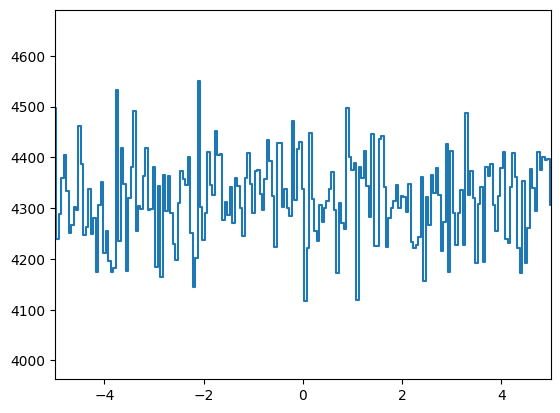

In [13]:
from matplotlib import pylab as plt

plt.figure()

plt.step(
    (lcs['ACS'][:,0] - t0_ijd)*24*3600,
    lcs['ACS'][:,2],
)

plt.xlim(-5,5)

In [14]:
def rebin(lc,n,av = False):
    if n == 0: return lc
    
    N=int(lc.shape[0]/n)*n
    if av:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).mean(1)
    else:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).sum(1)

In [15]:
# lcs['ACS']

lcs['ACS'][:,0].min()

8542.643544103374

total lc (12000, 4)
min -0.0034719151444733143
max 0.003471955602435628
expected telapse 600.0 telapse 599.9504325329326 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
b_tb 0.05000000000000001
acceptable, will be 1 0.05000000000000001
rebinned to (12000,)
{'meanrate': 86140.45166666665, 'maxrate': 93159.99999999999, 'stdvar': 1543.5915789689607, 'meanerr': 1312.5582018841424, 'excvar': 1.1760176247827914, 'maxsnr': 4.372860273240099, 'localfar': 0.07357752878433463, 'localfar_s': 1.7892315735624347}
requested scale 0.5
b_tb 0.05000000000000001
acceptable, will be 9 0.45000000000000007
rebinned to (1333,)
{'meanrate': 86140.07668583811, 'maxrate': 87906.66666666666, 'stdvar': 522.8918802876369, 'meanerr': 437.51844833697675, 'excvar': 1.1951310448168933, 'maxsnr': 3.3443797559525676, 'localfar': 0.5496410181563496, 'localfar_s': 0.5982981389730947}
requested scale 1
b_tb 0.05000000000000001
acceptable, will be 19 0.9500000000000002
rebinned to (631,)
{'meanrate':

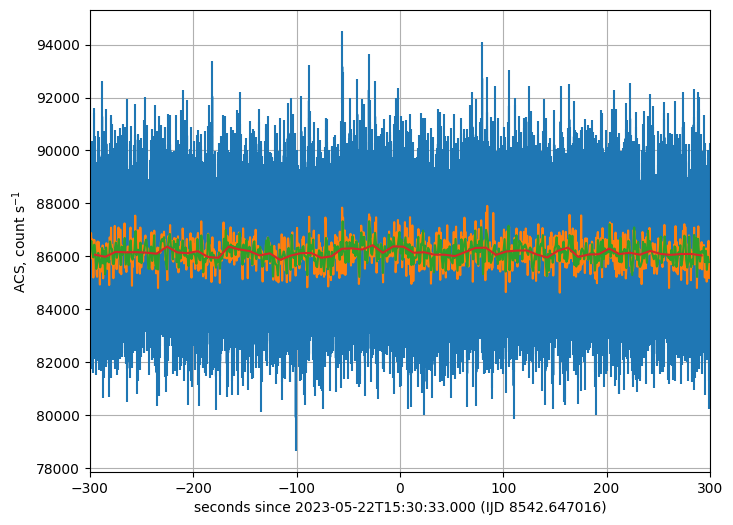

In [16]:
summary = dict()    

for n, lc in lcs.items():

    try:
        rel_s = (lc[:,0]-t0_ijd)*24*3600
    except:
        continue

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds

    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)

    lc = lc[m]

    b_tb = np.mean(lc[:,1])    

    rel_s = (lc[:,0]-t0_ijd)*24*3600

    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    

    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])


    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)

    if float(ontime) / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg completeness %s requireed %s"%(
            expected_telapse, telapse, ontime,
            ontime / expected_telapse, required_completeness))

    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary

    print("size", lc.shape, rel_s.shape)

    if np.sum(m) == 0: continue

    pylab.figure(figsize=(8,6))


    for ascale in [0.05, 0.5, 1, 10]:
        summary_scale = dict()
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = summary_scale        


        print("requested scale",ascale)
        print("b_tb",b_tb)

        if b_tb>ascale:
            ascale = b_tb


        nscale = int(ascale/b_tb)
        scale=nscale*b_tb

        print("acceptable, will be", nscale, scale)

        rate = rebin(lc[:,2],nscale,False)/scale
        rate_err = rebin(lc[:,2],nscale,False)**0.5/scale

        print("rebinned to",rate.shape)

        pylab.errorbar(
            rebin(rel_s,nscale,True),
            rate,
            rate_err,
            xerr=scale/4.
        )

        summary_scale['meanrate'] = np.mean(rate)
        summary_scale['maxrate'] = np.max(rate)
        summary_scale['stdvar'] = np.std(rate)
        summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
        summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

        summary_scale['maxsnr'] = np.max((rate-np.mean(rate))/rate_err/summary_scale['excvar'])

        summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

        summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0

        # add FAR spike here

        if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
            lc_summary['best'] = dict(
                localfar_s = summary_scale['localfar_s'],
                scale = ascale,
            )

        print(summary_scale)


    #tight_layout()
    pylab.grid()

    pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", count s$^{-1}$")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))

    fn=n.replace("/","_") + "_lc.png"
    pylab.savefig(fn)
    print("saving as",fn)
    break


In [17]:
# below S/N of 4 FAR is determined primarily by poisson, above - by spikes

def approx_FAR_spike_hz(snr, scale):    
    lim_snr = 2
    
    spike_rate_snr6 = 60./3600./24.
    if scale>=0.1:
        spike_rate_snr6*=(scale/0.1)**-1
    
    
    approx_FAR_hz = snr*0 + spike_rate_snr6 * (lim_snr/6.)**-2.7 
    
    try:
        if snr>lim_snr:
            approx_FAR_hz = spike_rate_snr6 * (np.abs(snr)/6.)**-2.7
    except:
        m=snr>lim_snr
        approx_FAR_hz[m] = (np.abs(snr[m])/6.)**-2.7 * spike_rate_snr6
        

    return approx_FAR_hz

def approx_FAR_norm_hz(snr, scale_s):
    return stats.norm.sf(snr)/scale_s

def approx_FAP(snr, t, scale_s):
    
    try:
        t_scaled = t[:]
        t_scaled[abs(t)<scale_s]=scale_s
    except:
        if abs(t)<scale_s:
            t_scaled=scale_s
        else:
            t_scaled=t

    approx_FAP = 2 * ( approx_FAR_norm_hz(snr, scale_s) + approx_FAR_spike_hz(snr, scale_s) )  * abs(t_scaled) * (1+np.log( 30/0.1))
    
    return approx_FAP



(1e-05, 30)

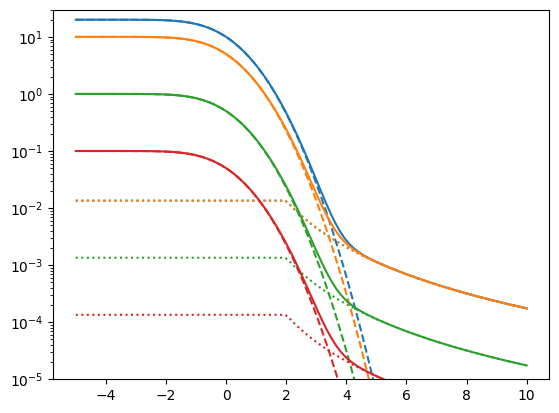

In [18]:
pylab.figure()

x=np.linspace(-5,10,100)

for scale_s in 0.05, 0.1, 1, 10:

    c=pylab.plot(x,approx_FAR_norm_hz(x, scale_s), ls='--')
    pylab.plot(x,approx_FAR_spike_hz(x, scale_s),c=c[0].get_color(),ls=":")
    pylab.plot(x,
               approx_FAR_spike_hz(x, scale_s) + approx_FAR_norm_hz(x, scale_s),
               c=c[0].get_color()
              )


    pylab.semilogy()

pylab.ylim([1e-5, 30])


In [19]:
timescales = sorted(set([0.05*ns for ns in sorted(set(
    list(map(int,np.logspace(0,np.log10(20*30),100))) 
))]  + list(np.linspace(1,31,30*2+1))))
timescales

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0,
 1.1,
 1.1500000000000001,
 1.25,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.85,
 1.9500000000000002,
 2.0,
 2.1,
 2.25,
 2.4000000000000004,
 2.5,
 2.5500000000000003,
 2.7,
 2.9000000000000004,
 3.0,
 3.1,
 3.3000000000000003,
 3.5,
 3.5500000000000003,
 3.75,
 4.0,
 4.3,
 4.5,
 4.6000000000000005,
 4.9,
 5.0,
 5.2,
 5.5,
 5.550000000000001,
 5.95,
 6.0,
 6.3500000000000005,
 6.5,
 6.75,
 7.0,
 7.2,
 7.5,
 7.7,
 8.0,
 8.200000000000001,
 8.5,
 8.75,
 9.0,
 9.35,
 9.5,
 10.0,
 10.5,
 10.65,
 11.0,
 11.350000000000001,
 11.5,
 12.0,
 12.100000000000001,
 12.5,
 12.950000000000001,
 13.0,
 13.5,
 13.8,
 14.0,
 14.5,
 14.700000000000001,
 15.0,
 15.5,
 15.700000000000001,
 16.0,
 16.5,
 16.75,
 17.0,
 17.5,
 17.85,
 18.0,
 18.5,
 19.0,
 1

In [20]:
summary = dict()    
all_excesses=[]            

best_lc=None

for n, lc in lcs.items():
    
    #rel_s = lc[:,0]
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds
    
    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)
    
    lc = lc[m]
   # rel_s = lc[:,0]
    
    b_tb = np.mean(lc[:,1])    
    
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    
    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    
    
    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])
        
    
    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)
    
    if ontime / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg"%(expected_telapse, telapse, ontime))
        
    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary
    
    print("size", lc.shape, rel_s.shape)
    
    if np.sum(m) == 0: continue
    
    pylab.figure(figsize=(8,6))
    
    best_lc_byscale={}

        
    
    #for ascale in [0.05, 0.1, 0.2, 0.5, 1, 2, 10]:
    for ascale in timescales:
    # for ascale in [0.05, 0.1, 0.5]:
    #for ascale in [0.05*i for i in range(20)] + [0.5*i for i in range(20)] + [15, 20, 25, 30]:
    #for ascale in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1, 2, 8, 10]:
    #for ascale in [1,]:
        s_scale_mo = {}
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = s_scale_mo    
        
        
        print("requested scale",ascale)
#        print("b_tb",b_tb)
        
        if b_tb>ascale:
            ascale = b_tb
                    
        
        nscale = int(round(ascale/b_tb))
        scale=nscale*b_tb

        print("true scale", scale)
        
#        print("acceptable, will be", nscale, scale)
        
        c=None
        
        
        #for offset in range(0,nscale):            
        #for offset in (, round(nscale/2)):            
        
        if nscale < 20:
            offsets = range(0, round(nscale/2)+1)
        else:
            offsets = range(0, round(nscale/2)+1, max(round(round(nscale/2)/20), 1))
        
        for offset in offsets: 
            summary_scale = dict()
            s_scale_mo[offset]=summary_scale
            
            rel_s_scale = rebin(rel_s[offset:], nscale, True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            #print("rebinned to",rate.shape)
            print("offset", offset, "rebinned to",rate.shape)
            
            
            summary_scale['scale_s']=scale
            summary_scale['meanrate'] = np.mean(rate)
            summary_scale['maxrate'] = np.max(rate)            
            summary_scale['stdvar'] = np.std(rate)
            summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
            summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

            print("summary_scale['excvar']", summary_scale['excvar'])

            if negative_excesses==1:
                snr = -(rate-np.mean(rate))/rate_err/summary_scale['excvar']
            else:
                snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']
            
            i_max = np.argmax(snr)
            
            print(i_max,snr[i_max],rel_s_scale[i_max])
            
            summary_scale['maxsnr'] = snr[i_max]
            summary_scale['maxsnr_t'] = rel_s_scale[i_max]

            summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

            summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0
            
            m_over_threshold = snr > global_snr_threshold
                        
            excesses = dict(
                            snr = snr[m_over_threshold],
                            rel_s_scale = rel_s_scale[m_over_threshold],
                            rate = rate[m_over_threshold],
                            rate_err = rate_err[m_over_threshold],
                            rate_overbkg = rate[m_over_threshold] - np.mean(rate),
                        )
                        
            summary_scale['excesses'] = [dict(zip(excesses.keys(), er)) for er in zip(*excesses.values())]

            for e in summary_scale['excesses']:
                e['FAP'] = approx_FAP(e['snr'], e['rel_s_scale'], scale)
            
            all_excesses+=[
                        dict(scale=scale, offset=offset,excess=e) for e in summary_scale['excesses']
                    ]

            print("scale", scale, "offset", offset, "found excesses",len(summary_scale['excesses']))                        

            #r=pylab.errorbar(
            #    rebin(rel_s[offset:],nscale,True),
            #    rate,
            #    rate_err,
            #    xerr=scale/4.,
            #    c=c,
            #    alpha=0.7
            #)
            
        #    print(rel_s_scale.shape, snr.shape)
            
            r = pylab.errorbar(
                rel_s_scale,
                snr,
                snr*0+1,
                xerr=scale/4.,
                c=c,
                alpha=0.7
            )
            
            pylab.axvline(summary_scale['maxsnr_t'],c="k")
            
            
            c=r[0].get_color()

            
            # add FAR spike here

            if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
                lc_summary['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
                best_lc=rel_s_scale,rate,rate_err
            
            if 'best' not in s_scale_mo or summary_scale['localfar_s'] > s_scale_mo['best']['localfar_s']:
                s_scale_mo['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
              #  best_lc=rel_s_scale,rate,rate_err
            
            if ascale not in best_lc_byscale or summary_scale['localfar_s'] > best_lc_byscale[ascale]['localfar_s']:
                best_lc_byscale[ascale] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                    best_lc=(rel_s_scale,rate,rate_err),
                )
                
        
            #print(summary_scale)
        s_scale_mo.update(s_scale_mo['best']['summary_scale'])

    #tight_layout()
    pylab.grid()

    #pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", S/N")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))
    pylab.xlim([-10, 10])
    
    detfn=n.replace("/","_") + "_det_lc.png"
    pylab.savefig(detfn)
    print("saving as",detfn)
    
summary['ACS']['best']

total lc (12000, 4)
min -0.0034719151444733143
max 0.003471955602435628
expected telapse 600.0 telapse 599.9504325329326 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
true scale 0.05000000000000001
offset 0 rebinned to (12000,)
summary_scale['excvar'] 1.1760176247827914
4884 4.372860273240099 -55.773294501705095
scale 0.05000000000000001 offset 0 found excesses 20
requested scale 0.1
true scale 0.10000000000000002
offset 0 rebinned to (6000,)
summary_scale['excvar'] 1.1834610953151208
2119 4.010820187628551 -88.04831628513057
scale 0.10000000000000002 offset 0 found excesses 9
offset 1 rebinned to (5999,)
summary_scale['excvar'] 1.1790364278101209
1183 3.991371179752919 -181.59838344727177
scale 0.10000000000000002 offset 1 found excesses 10
requested scale 0.15000000000000002
true scale 0.15000000000000002
offset 0 rebinned to (4000,)
summary_scale['excvar'] 1.1727685349179429
1520 3.4265096264549464 -71.92330633406527
scale 0.15000000000000002 offset 0 found 

In [ ]:
plt.figure()


snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']

plt.step(
    rel_s_scale,
    rate
)
plt.xlim(-200,200)
            

In [ ]:
for e in all_excesses:
    if np.abs(e['scale'] - 0.05)< 0.001:
        # if np.abs(e['excess']['rel_s_scale']) < 5:
        print(e['excess']['rel_s_scale'], e)

In [ ]:
grouped_excesses = []

for i in sorted(all_excesses, key=lambda x:x['excess']['FAP']):
    if i['excess']['FAP']<1 or True:
        print(i['scale'],i['offset'], i['excess']['snr'], i['excess']['rel_s_scale'], i['excess']['FAP'])
        
        grouped=False
        for g in grouped_excesses:
            if abs(i['excess']['rel_s_scale']-g['excess']['rel_s_scale'])<max(i['scale'],g['scale']):
                print("to group", g['excess']['rel_s_scale'])
                if i['excess']['snr'] > g['excess']['snr']:
                    print("group takeover")
                    g.update(i)
                grouped=True
                
        if not grouped:
            print("new group")
            #i['group']=[i]
            grouped_excesses.append(i)
        
    

In [ ]:
grouped_excesses=sorted(grouped_excesses, key=lambda x:x['excess']['FAP'])

for i in grouped_excesses:
    print(f"timescale {i['scale']:4.2f}   S/N {i['excess']['snr']:5.2f}   T0+{i['excess']['rel_s_scale']:7.1f}   FAP {i['excess']['FAP']:7.5f}")

In [ ]:
import json

len(json.dumps(grouped_excesses))

In [ ]:
summary['ACS']['best']

In [ ]:
#T

In [ ]:
summary['ACS']['s_8']

In [ ]:
excvar_summary=dict(
)

for k,s in summary['ACS'].items():
    if 'scale_s' in s:
        print("%.5lg"%s['scale_s'], "%5.4lg"%s['excvar'])
        
        if s['scale_s']<=0.200:
            kg='hf_200ms'
        elif s['scale_s']<=2.00:
            kg='mf_200ms_2s'
        elif s['scale_s']<=10.00:
            kg='mf_2s_10s'
        else:
            kg='lf_10s'
        
        if kg not in excvar_summary:
            excvar_summary[kg]=[s['excvar']]
        else:
            excvar_summary[kg]+=[s['excvar']]

for k,v in excvar_summary.items():
    print(k,min(v),max(v))

In [ ]:
fig_names=[]


for limit_group in 0.02, 0.1, 1: 
    figs=dict()

    for n, lc in lcs.items():
        rel_s = (lc[:,0]-t0_ijd)*24*3600

        m = rel_s>-tstart_rel_mseconds
        m &= rel_s<tstop_rel_seconds

        print("total lc",lc.shape)
        print("min",lc[:,0].min()-t0_ijd)
        print("max",lc[:,0].max()-t0_ijd)

        lc = lc[m]
        rel_s = rel_s[m]

        for excess in grouped_excesses:
            #if excess['excess']['FAP'] > 0.02: continue
            if excess['excess']['FAP'] > limit_group: continue

            print(excess)


            offset = excess['offset']
            nscale = int(excess['scale']/b_tb)  
            scale=excess['scale']

            s_figs = sorted(figs.items(), key=lambda x:abs(x[0]-scale))

            if len(s_figs) == 0 or s_figs[0][0] < scale*0.5 or s_figs[0][0] > scale*1.5: 
                fig = pylab.figure(figsize=(8,6))
                figs[scale] = fig
                pylab.xlim([-2,2])
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")
                pylab.title("FAP threshold %.5lg"%limit_group)
            else:            
                print("good match", s_figs[0][0], scale)
                pylab.figure(s_figs[0][1].number)
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")



            rel_s_scale = rebin(rel_s[offset:],nscale,True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            bkg=np.mean(rate)

            m_on = np.abs(rel_s_scale-excess['excess']['rel_s_scale'])<excess['scale']*1.5


            pylab.grid(False)

            pylab.axhline(0, alpha=0.2, ls=":", color='gray')

            cr=pylab.errorbar(
                    rel_s_scale, 
                    (rate-bkg), 
                    (rate_err),
                    alpha=0.5,
                    ls="",
                )[0].get_color()

            pylab.step(
                    rel_s_scale, 
                    (rate-bkg), 
              #      (rate_err),
                    alpha=0.5,
                    where="mid",
                    c=cr,
                )

            pylab.axhline(np.std(rate)*3, alpha=0.2, ls="--",c=cr)
            pylab.axhline(np.std(rate)*5, alpha=0.2, ls="--", lw=2,c=cr)






            pylab.errorbar(
                    rel_s_scale[m_on], 
                    (rate-bkg)[m_on], 
                    (rate_err)[m_on],
                    lw=2.,
                    alpha=1,
                    label="S/N %.3lg FAP %.3lg scale %.3lg s"%(excess['excess']['snr'],excess['excess']['FAP'],excess['scale']),
                    c=cr
                )



            newlim=([
                min([excess['excess']['rel_s_scale']*1.3-excess['scale']*5,-excess['scale']*5]),
                max([excess['excess']['rel_s_scale']*1.3+excess['scale']*5,excess['scale']*5]),
            ])

            oldlim=pylab.gca().get_xlim()

            print(oldlim)

            pylab.xlim([
                min([oldlim[0],newlim[0]]),
                max([oldlim[1],newlim[1]]),
            ])


    for f_i,(s,f) in enumerate(figs.items()):
        f.legend()
        f.gca().axvline(0,ls="--",c="r",lw=3)
        fn="excess_%.5lg_%i.png"%(s,len(fig_names))
        f.savefig(fn)
        fig_names.append(fn)






In [ ]:
cols=1
rows=int(np.ceil(len(fig_names)/cols))


if rows>0:
    f, axes=pylab.subplots(rows, cols, figsize=(12, 8*rows))
    print("axes",axes,axes.__class__)

    if rows>1:
        axes=axes.flatten()
    else:
        axes=[axes]

    for i,fn in enumerate(fig_names):
        #f.add_subplot(len(fig_names), 2, i+1)
        axes[i].axis('off')
        axes[i].imshow(pylab.imread(fn) ) #, extent=(0,1,0,1))
        #pylab.imshow(pylab.imread(fn), extent=(0,1,(i-1)/len(fig_names),i/len(fig_names)))

    f.tight_layout()
else:
    f=pylab.figure()

f.savefig("excesses_mosaic.png")

In [ ]:
if rt == 1:    
    summary['ACS_rt'] = summary['ACS']

In [ ]:
summary['ACS']['s_1']['meanerr']

In [ ]:
import json

json.dump(dict(
    summary=summary,
    reportable_excesses=grouped_excesses,
    excvar_summary=excvar_summary
), open("integral_all_sky.json","w"), indent=4)

In [ ]:
acs_lc_png="ACS_lc.png"
acs_rt_lc_png="ACS_lc.png"
acs_rt_det_lc_png="ACS_det_lc.png"
ibis_veto_lc_png="IBIS_Veto_lc.png"
excesses_mosaic_png="excesses_mosaic.png"
summary=summary
reportable_excesses=grouped_excesses
excvar_summary=excvar_summary